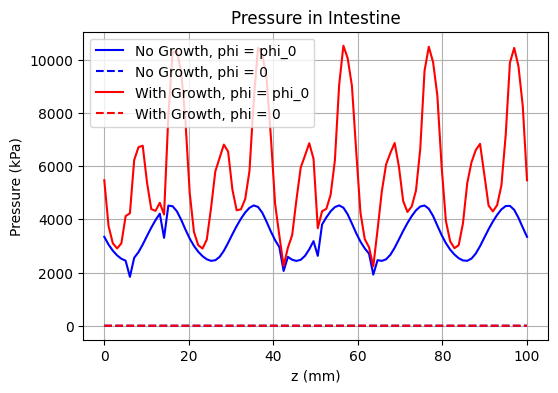

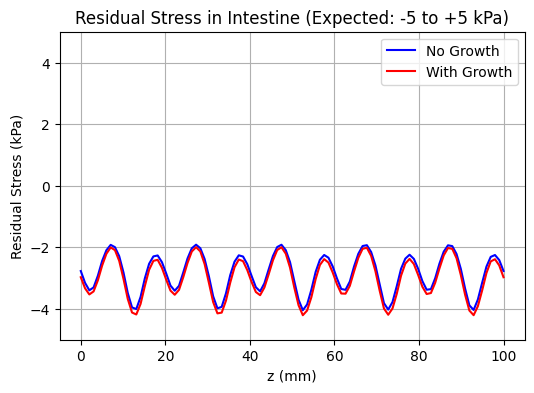

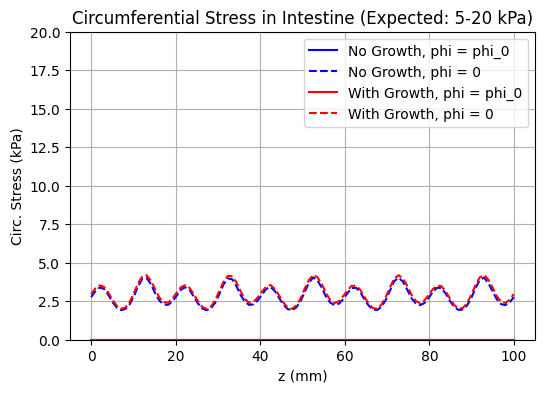

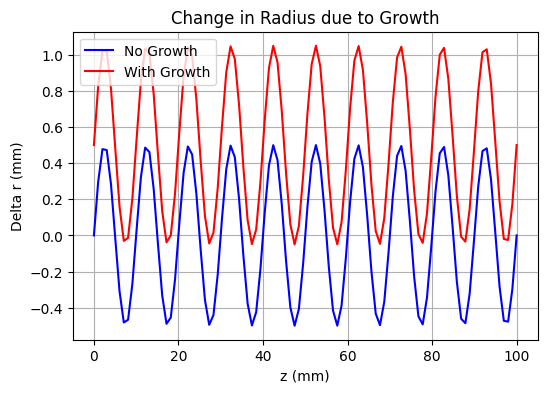

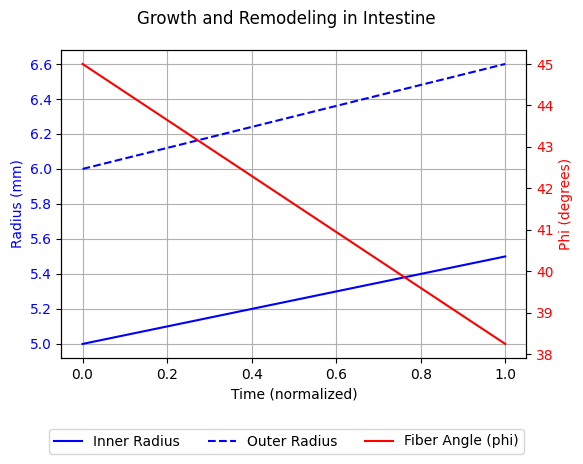

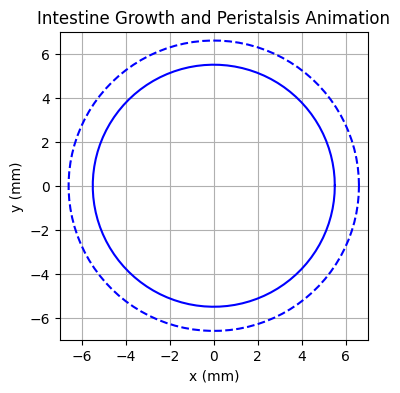

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

length = 100.0  # Length of intestine segment (mm)
z = np.linspace(0, length, 100)  # Axial coordinate along intestine
base_radius = 5.0  # Base inner radius (mm)

# Wall layers (mucosa, submucosa, muscularis, serosa)
layer_thickness = [0.3, 0.2, 0.4, 0.1]  # Thickness of each layer (mm)
inner_radius = base_radius + 0.5 * np.sin(2 * np.pi * z / 10)  # Sinusoidal variation for villi
outer_radius = inner_radius + sum(layer_thickness)

# Layer-specific material properties
c_layers = [2.0, 3.0, 6.0, 1.0]  # kPa
alpha_1_layers = [0.01, 0.02, 0.03, 0.01]
alpha_2_layers = [0.5, 0.6, 0.7, 0.4]
alpha_3_layers = [-0.1, -0.2, -0.3, -0.1]
phi_0_layers = [90 * np.pi / 180, 90 * np.pi / 180, 45 * np.pi / 180, 90 * np.pi / 180]

# Peristaltic Wave Parameters
peristaltic_amplitude = 0.2  # Amplitude of radius change (mm)
peristaltic_frequency = 0.1  # Frequency (Hz)
peristaltic_speed = 20.0  # Speed (mm/s)

def W(I_1, layer_idx):
    term = max(I_1 - 3, 0)  # Avoid negative terms
    c = c_layers[layer_idx]
    alpha_1 = alpha_1_layers[layer_idx]
    alpha_2 = alpha_2_layers[layer_idx]
    alpha_3 = alpha_3_layers[layer_idx]
    return c / 2 * term + alpha_1 * term**2 + alpha_2 * term**3 + alpha_3 * term**4

# Nonlinear Growth Factor
def growth_factor(r, sigma, z):
    sigma_ref = 10.0  # Homeostatic stress (kPa)
    K_plus = 0.05
    base_growth = 1 + 0.1 * np.exp(-((r - (inner_radius.mean() + outer_radius.mean()) / 2) ** 2) / (0.4 * sum(layer_thickness) ** 2))
    mech_feedback = 1 + K_plus * max(sigma / sigma_ref - 1, 0)
    return min(base_growth * mech_feedback, 1.2)  # Limit growth to 20%

# Stretch Ratios
def stretch_ratios(r, phi, g, z, t):
    r_local = inner_radius[np.argmin(np.abs(z - z.mean()))]
    peristaltic_effect = peristaltic_amplitude * np.sin(2 * np.pi * peristaltic_frequency * t - 2 * np.pi * z / peristaltic_speed)
    r_adjusted = r + peristaltic_effect
    if abs(phi) < 1e-10:
        lambda_theta = r_adjusted / r_local
        lambda_r = 1.0
    else:
        theta_0 = 2 * np.pi - phi
        lambda_theta = (theta_0 / (2 * np.pi)) * (outer_radius.mean() / sum(layer_thickness)) * (r_adjusted / (r / g))
        lambda_r = 1 / lambda_theta
    lambda_z = 1.0 * g
    return lambda_r, lambda_theta, lambda_z

def invariants(lambda_r, lambda_theta, lambda_z):
    return lambda_r**2 + lambda_theta**2 + lambda_z**2

def pressure_ode(p, r, phi, g, z, t, layer_idx):
    lambda_r, lambda_theta, lambda_z = stretch_ratios(r, phi, g, z, t)
    I_1 = invariants(lambda_r, lambda_theta, lambda_z)
    term = max(I_1 - 3, 0)
    dW_dI1 = c_layers[layer_idx] / 2 + 2 * alpha_1_layers[layer_idx] * term + 3 * alpha_2_layers[layer_idx] * term**2 + 4 * alpha_3_layers[layer_idx] * term**3
    if np.abs(lambda_r**2 * lambda_theta**2) < 1e-10:
        dp_dr = 0
    else:
        dp_dr = -(lambda_theta**2 - lambda_r**2) / (lambda_r**2 * lambda_theta**2) * dW_dI1
    return dp_dr

# Circumferential Stress
def circ_stress(r, phi, p, g, z, t, layer_idx):
    lambda_r, lambda_theta, lambda_z = stretch_ratios(r, phi, g, z, t)
    I_1 = invariants(lambda_r, lambda_theta, lambda_z)
    term = max(I_1 - 3, 0)
    dW_dI1 = c_layers[layer_idx] / 2 + 2 * alpha_1_layers[layer_idx] * term + 3 * alpha_2_layers[layer_idx] * term**2 + 4 * alpha_3_layers[layer_idx] * term**3
    sigma_theta = lambda_theta**2 * dW_dI1 - p
    return max(min(sigma_theta, 20.0), 0.0)

def remodeling_factor(t):
    return phi_0_layers[2] * (1 - 0.15 * t)

t = 0.0
r_range = np.linspace(inner_radius.min(), outer_radius.max(), 100)
pressure_no_growth = np.zeros(len(z))
pressure_with_growth = np.zeros(len(z))
circ_stress_no_growth = np.zeros(len(z))
circ_stress_with_growth = np.zeros(len(z))
pressure_no_growth_phi0 = np.zeros(len(z))
pressure_with_growth_phi0 = np.zeros(len(z))
circ_stress_no_growth_phi0 = np.zeros(len(z))
circ_stress_with_growth_phi0 = np.zeros(len(z))

for i, z_i in enumerate(z):
    layer_stress_ng = 0
    layer_stress_wg = 0
    layer_stress_ng_phi0 = 0
    layer_stress_wg_phi0 = 0
    for layer_idx in range(len(layer_thickness)):
        r_start = inner_radius[i] + sum(layer_thickness[:layer_idx])
        r_end = r_start + layer_thickness[layer_idx]
        r_layer = r_range[(r_range >= r_start) & (r_range <= r_end)]

        if len(r_layer) > 1:
            p0 = [0]
            # No growth, phi = phi_0
            p_ng = odeint(pressure_ode, p0, r_layer, args=(phi_0_layers[layer_idx], 1.0, z_i, t, layer_idx)).flatten()
            sigma_ng = circ_stress(r_layer[-1], phi_0_layers[layer_idx], p_ng[-1], 1.0, z_i, t, layer_idx)
            # No growth, phi = 0
            p_ng_phi0 = odeint(pressure_ode, p0, r_layer, args=(0, 1.0, z_i, t, layer_idx)).flatten()
            sigma_ng_phi0 = circ_stress(r_layer[-1], 0, p_ng_phi0[-1], 1.0, z_i, t, layer_idx)
            # With growth, phi = phi_0
            g = growth_factor(r_layer[-1], sigma_ng, z_i)
            p_wg = odeint(pressure_ode, p0, r_layer, args=(phi_0_layers[layer_idx], g, z_i, t, layer_idx)).flatten()
            sigma_wg = circ_stress(r_layer[-1], phi_0_layers[layer_idx], p_wg[-1], g, z_i, t, layer_idx)
            # With growth, phi = 0
            p_wg_phi0 = odeint(pressure_ode, p0, r_layer, args=(0, g, z_i, t, layer_idx)).flatten()
            sigma_wg_phi0 = circ_stress(r_layer[-1], 0, p_wg_phi0[-1], g, z_i, t, layer_idx)

            weight = layer_thickness[layer_idx] / sum(layer_thickness)
            layer_stress_ng += sigma_ng * weight
            layer_stress_wg += sigma_wg * weight
            layer_stress_ng_phi0 += sigma_ng_phi0 * weight
            layer_stress_wg_phi0 += sigma_wg_phi0 * weight

            if layer_idx == len(layer_thickness) - 1:
                pressure_no_growth[i] = p_ng[-1]
                pressure_with_growth[i] = p_wg[-1]
                pressure_no_growth_phi0[i] = p_ng_phi0[-1]
                pressure_with_growth_phi0[i] = p_wg_phi0[-1]

    circ_stress_no_growth[i] = layer_stress_ng
    circ_stress_with_growth[i] = layer_stress_wg
    circ_stress_no_growth_phi0[i] = layer_stress_ng_phi0
    circ_stress_with_growth_phi0[i] = layer_stress_wg_phi0

# Compute residual stress
residual_stress_no_growth = circ_stress_no_growth - circ_stress_no_growth_phi0
residual_stress_with_growth = circ_stress_with_growth - circ_stress_with_growth_phi0

# Compute change in radius
delta_r_no_growth = inner_radius - inner_radius.mean()
delta_r_with_growth = inner_radius * (1 + 0.1) - inner_radius.mean()

time_steps = np.linspace(0, 1, 100)
r_inner_over_time = [inner_radius.mean() * (1 + 0.1 * t) for t in time_steps]
r_outer_over_time = [outer_radius.mean() * (1 + 0.1 * t) for t in time_steps]
phi_over_time = [remodeling_factor(t) * 180 / np.pi for t in time_steps]

plt.figure(figsize=(6, 4))
plt.plot(z, pressure_no_growth, 'b-', label='No Growth, phi = phi_0')
plt.plot(z, pressure_no_growth_phi0, 'b--', label='No Growth, phi = 0')
plt.plot(z, pressure_with_growth, 'r-', label='With Growth, phi = phi_0')
plt.plot(z, pressure_with_growth_phi0, 'r--', label='With Growth, phi = 0')
plt.grid(True)
plt.xlabel('z (mm)')
plt.ylabel('Pressure (kPa)')
plt.title('Pressure in Intestine')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(z, residual_stress_no_growth, 'b-', label='No Growth')
plt.plot(z, residual_stress_with_growth, 'r-', label='With Growth')
plt.grid(True)
plt.xlabel('z (mm)')
plt.ylabel('Residual Stress (kPa)')
plt.title('Residual Stress in Intestine (Expected: -5 to +5 kPa)')
plt.legend()
plt.ylim(-5, 5)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(z, circ_stress_no_growth, 'b-', label='No Growth, phi = phi_0')
plt.plot(z, circ_stress_no_growth_phi0, 'b--', label='No Growth, phi = 0')
plt.plot(z, circ_stress_with_growth, 'r-', label='With Growth, phi = phi_0')
plt.plot(z, circ_stress_with_growth_phi0, 'r--', label='With Growth, phi = 0')
plt.grid(True)
plt.xlabel('z (mm)')
plt.ylabel('Circ. Stress (kPa)')
plt.title('Circumferential Stress in Intestine (Expected: 5-20 kPa)')
plt.legend()
plt.ylim(0, 20)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(z, delta_r_no_growth, 'b-', label='No Growth')
plt.plot(z, delta_r_with_growth, 'r-', label='With Growth')
plt.grid(True)
plt.xlabel('z (mm)')
plt.ylabel('Delta r (mm)')
plt.title('Change in Radius due to Growth')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(time_steps, r_inner_over_time, 'b-', label='Inner Radius')
ax1.plot(time_steps, r_outer_over_time, 'b--', label='Outer Radius')
ax1.set_xlabel('Time (normalized)')
ax1.set_ylabel('Radius (mm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(time_steps, phi_over_time, 'r-', label='Fiber Angle (phi)')
ax2.set_ylabel('Phi (degrees)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.suptitle('Growth and Remodeling in Intestine')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
theta = np.linspace(0, 2 * np.pi, 100)
line_inner, = ax.plot([], [], 'b-')
line_outer, = ax.plot([], [], 'b--')
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.grid(True)
ax.set_aspect('equal')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title('Intestine Growth and Peristalsis Animation')

def init():
    line_inner.set_data([], [])
    line_outer.set_data([], [])
    return line_inner, line_outer

def update(frame):
    t = frame / 20.0
    g_t = 1 + 0.1 * frame / 100
    r_inner = inner_radius.mean() * g_t
    r_outer = outer_radius.mean() * g_t
    peristaltic_effect = peristaltic_amplitude * np.sin(2 * np.pi * peristaltic_frequency * t)
    x_inner = (r_inner + peristaltic_effect) * np.cos(theta)
    y_inner = (r_inner + peristaltic_effect) * np.sin(theta)
    x_outer = (r_outer + peristaltic_effect) * np.cos(theta)
    y_outer = (r_outer + peristaltic_effect) * np.sin(theta)
    line_inner.set_data(x_inner, y_inner)
    line_outer.set_data(x_outer, y_outer)
    return line_inner, line_outer

ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True, interval=50)
writer = PillowWriter(fps=20)
ani.save("intestine_growth_peristalsis.gif", writer=writer)
plt.show()